In [17]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import networkx as nx
import time

In [18]:
# Lee el archivo. En la carpeta en dónde se ejecute el notebook debe estar el archivo
# Cambiar el nombre de la instancia para cambiar el archivo de lectura (pero el archivo de la instancia debe estar en la carpeta)
file_path = os.path.join(os.getcwd(), "gdb1.dat")
with open(file_path, "r") as file:
    texto = file.read()

# Expresión regular para extraer los arcos
arcos = {
    (int(n1), int(n2)): [int(c), int(d)]
    for n1, n2, c, d in re.findall(r"\(\s*(\d+),\s*(\d+)\)\s+coste\s+(\d+)\s+demanda\s+(\d+)", texto)
}

# Expresión regular para capturar el número después de "DEPOSITO :"
match = re.search(r"DEPOSITO\s*:\s*(\d+)", texto)
depot=int(match.groups()[0])

# Expresión regular para capturar el número después de "VEHICULOS :"
match1 = re.search(r"VEHICULOS\s*:\s*(\d+)", texto)
veh=int(match1.groups()[0])

# Expresión regular para capturar el número después de "CAPACIDAD :"
match2 = re.search(r"CAPACIDAD\s*:\s*(\d+)", texto)
veh_cap=int(match2.groups()[0])

#Imprime los parámetros 
print("Nodo del Depósito: ", depot)
print("Número de Vehículos: ",veh)
print("Capacidad de cada Vehículo: ",veh_cap)

Nodo del Depósito:  1
Número de Vehículos:  5
Capacidad de cada Vehículo:  5


In [19]:
# Creación del grafo 
G = nx.Graph()

# Agregar nodos y aristas con atributos (basado en el diccionario de atributo de arcos leído del archivo .dat)
for (n1, n2), (coste, demanda) in arcos.items():
    G.add_edge(n1, n2, weight=coste, demanda=demanda)


# Impresión de los nodos
nodos=list(G.nodes())
print(nodos)
nodos.remove(depot)
print(nodos)



[1, 2, 4, 7, 10, 12, 3, 9, 5, 6, 11, 8]
[2, 4, 7, 10, 12, 3, 9, 5, 6, 11, 8]


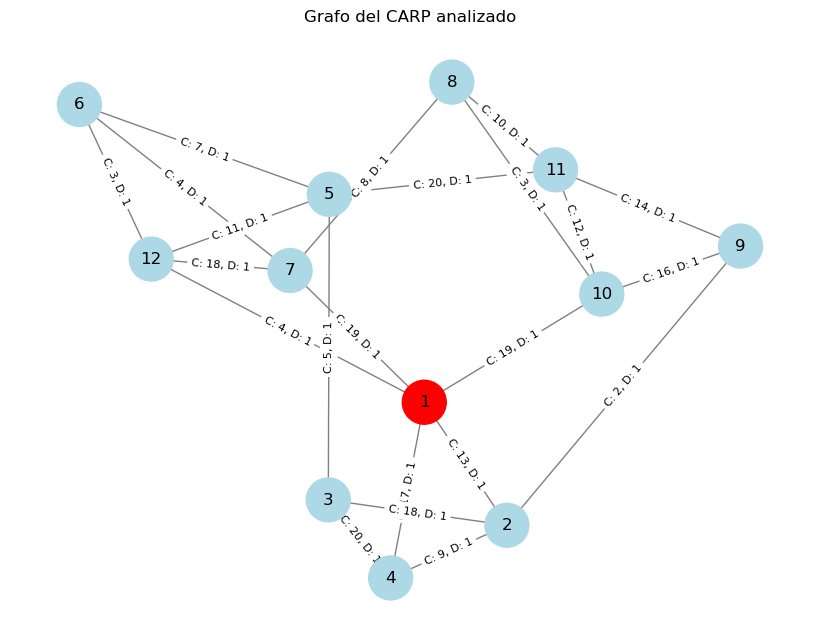

In [20]:
# Dibujo del Grafo. (como no hay coordenadas de distancia, graficado con la forma planar)

seed=8 #fija la semilla aleatoria para cualquier cambio de vista (por ejemplo random)
pos = nx.spring_layout(G)  # Carga el gráfico basado en el grafo creado

#Creación de las notas de los arcos
edge_labels = {(n1, n2): f"C: {coste}, D: {demanda}" for (n1, n2), (coste, demanda) in arcos.items()}

plt.figure(figsize=(8, 6))
#Definición de los colores (separa el depósito para visualización)
node_colors = ["red" if node == depot else "lightblue" for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, edge_color='gray', font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Grafo del CARP analizado")
plt.show()

In [21]:
data=list(G.edges(data=True))
print(data[0])
print(data[0][2]["weight"])
print(arcos)

# Ordena el listado de arcos según la proporción demanda/costo (mejor precio unitario atendido)
arcos_org = sorted(arcos.items(), key=lambda x: x[1][0]/x[1][1])

print(arcos_org)


(1, 2, {'weight': 13, 'demanda': 1})
13
{(1, 2): [13, 1], (1, 4): [17, 1], (1, 7): [19, 1], (1, 10): [19, 1], (1, 12): [4, 1], (2, 3): [18, 1], (2, 4): [9, 1], (2, 9): [2, 1], (3, 4): [20, 1], (3, 5): [5, 1], (5, 6): [7, 1], (5, 11): [20, 1], (5, 12): [11, 1], (6, 7): [4, 1], (6, 12): [3, 1], (7, 8): [8, 1], (7, 12): [18, 1], (8, 10): [3, 1], (8, 11): [10, 1], (9, 10): [16, 1], (9, 11): [14, 1], (10, 11): [12, 1]}
[((2, 9), [2, 1]), ((6, 12), [3, 1]), ((8, 10), [3, 1]), ((1, 12), [4, 1]), ((6, 7), [4, 1]), ((3, 5), [5, 1]), ((5, 6), [7, 1]), ((7, 8), [8, 1]), ((2, 4), [9, 1]), ((8, 11), [10, 1]), ((5, 12), [11, 1]), ((10, 11), [12, 1]), ((1, 2), [13, 1]), ((9, 11), [14, 1]), ((9, 10), [16, 1]), ((1, 4), [17, 1]), ((2, 3), [18, 1]), ((7, 12), [18, 1]), ((1, 7), [19, 1]), ((1, 10), [19, 1]), ((3, 4), [20, 1]), ((5, 11), [20, 1])]


In [22]:
def carp_imp(G,depot):
    # para seleccionar los primeros candidatos para la asignación, se buscarán esos arcos que atiendan más demanda a un menor costo
    a=nx.adjacency_matrix(G,nodelist=range(1,len(G.nodes())+1))
    d=nx.adjacency_matrix(G,nodelist=range(1,len(G.nodes())+1),weight="demanda")

    #as matrix operations will be done, adjustement to have number adjusted to python indexing
    new_depot=depot-1

    #costos de salida de esos nodos
    cost_out=a.todense()

    #inicialización del grafo que se modificará para hacer la asignación de los arcos en diferentes rutas
    graph_i=nx.Graph(a)

    #inicialización de la lista con la cual se validará si se recorren todos los arcos de un grafo
    check=list(graph_i.edges())

    #Listas vacías para almacenar los datos de las rutas, costos y demandas atendidas por rutas
    routes=[]
    costs=[]
    demand_a=[]

    #contador de seguridad para no generar un loop infinito
    cont=0
    #bandera útil apra que el ciclo no se quede parado buscando los mínimos. Se activa cuando el ruteo por método de mínimos empieza 
    num_aux=0


    #Mientras hayan arcos sin ser recorridos
    while len(check)>0 and cont<100:

        # número de nodos con demanda que recibe este nodo que tiene asociado cada nodo
        conn=d.todense()
        cost_out[cost_out==0] = 1
        b_arc=conn/cost_out
        b_arc[np.isnan(b_arc)] = 0
        # print(b_arc)
        # print(b_arc.sum(axis=1))
        #evacuemos primero el que tiene más demanda
        node_i=np.argmax(b_arc.sum(axis=1))
        # print(node_i)
        if node_i==0:
            node_i+=1
        # print("pending to be assigned",len(check))

        # if 0 in conn:
        #     print("enter")
        #     poss=np.argwhere(conn>0)
        #     print(poss)
        #     node_i=poss[0][0]
        # print("new: ",node_i)

        #best route
        if num_aux==0:
            #saquemos la ruta más corta entre el nodo con más demanda y el depósito
            cost,nodes=nx.single_source_dijkstra(graph_i, node_i, depot-1)

            #calculemos el costo original (útil si estamos modificando los costos para seleccionar diferentes rutas)
            cost_aux=nx.single_source_dijkstra(G, node_i+1,depot)[0]

            #asigna los costos de la ruta según los valores originales
            if (cost!=cost_aux):
                cost=cost_aux

            #Si el nodo con mayores demandas no es el depot, vamos a hacer la ruta desde el depot hasta el nodo para dar inicio
            if nodes[0]!=0:
                cost_i,n_i=nx.single_source_dijkstra(G, depot,node_i+1)
                cost+=cost_i
                n_i=[n_i[i]-1 for i in range(len(n_i))]
                n_i.pop(-1)
                nodes=n_i+nodes


        else:
            n_ix,n_fx=check[0]
            # print("ini", n_ix)
            # print("fin",n_fx)
            #saquemos la ruta más corta entre el nodo del extremo del arco hayado y el depósito
            cost,nodes=nx.single_source_dijkstra(graph_i, n_fx, depot-1)

            #calculemos el costo original (útil si estamos modificando los costos para seleccionar diferentes rutas)
            cost_aux=nx.single_source_dijkstra(G, n_fx+1,depot)[0]

            #asigna los costos de la ruta según los valores originales
            if (cost!=cost_aux):
                cost=cost_aux

            #Si el nodo con mayores demandas no es el depot, vamos a hacer la ruta desde el depot hasta el nodo para dar inicio
            if n_ix!=0:
                cost_i,n_i=nx.single_source_dijkstra(G, depot,n_ix+1)
                cost+=cost_i
                # print("\n FLAGGGGGGGG \n", a[n_ix,n_fx])
                # print("ruta a nodo inicial: ",n_i)
                cost+=a[n_ix,n_fx]
                n_i=[n_i[i]-1 for i in range(len(n_i))]
                n_i.pop(-1)
                nodes=n_i+[n_ix]+nodes
            else:
                n_i=[i for i in check[0]]
                cost_i=a[n_ix,n_fx]
                cost+=cost_i
                nodes=n_i+nodes
            # print("test: ", nodes)
        #crea la secuencia del recorrido de los arcos de la ruta evaluada
        route_i=[(nodes[i-1],nodes[i]) for i in range(1,len(nodes))]
        # print(route_i)
        dem_i=0
        flag=0
            #evalúa cada nodo de la ruta para saber si está o no ya recorrido
        for r in route_i:
            #si el arco no ha sido recorrido
            if (r in check):
                    #almacena cuanta demanda se está atendiendo en el arco
                dem_i+=d[r[0]-1,r[1]-1]
                    #en la amtriz de demandas se coloca 0 para representar que ya se atendió la demanda
                d[r[0]-1,r[1]-1]=0
                d[r[1]-1,r[0]-1]=0
                    #se modifica el grafo para que los arcos sean más costosos (y que el método de RMC no eliga este dentro de la ruta)
                graph_i[r[0]][r[1]]['weight']*=4
                    #modifica la lista para saber que ya se recorrió
                check.remove(r)
                    #si un arco se recorre, activa el condicional para almacenar la información del recorrido
                flag=1

            else: 
                num_aux+=1
        if flag==1:
            routes.append(route_i)
            demand_a.append(dem_i)
            costs.append(cost)
            num_aux=0
        cont+=1
    return (sum(costs),len(check),routes)






In [ ]:
def archivo_ejec(filename):
    # Lee el archivo. En la carpeta en dónde se ejecute el notebook debe estar el archivo
    # Cambiar el nombre de la instancia para cambiar el archivo de lectura (pero el archivo de la instancia debe estar en la carpeta)
    file_path = os.path.join(os.getcwd(), filename+".dat")
    with open(file_path, "r") as file:
        texto = file.read()

    # Expresión regular para extraer los arcos
    arcos = {
        (int(n1), int(n2)): [int(c), int(d)]
        for n1, n2, c, d in re.findall(r"\(\s*(\d+),\s*(\d+)\)\s+coste\s+(\d+)\s+demanda\s+(\d+)", texto)
    }

    # Expresión regular para capturar el número después de "DEPOSITO :"
    match = re.search(r"DEPOSITO\s*:\s*(\d+)", texto)
    depot_i=int(match.groups()[0])

    # Expresión regular para capturar el número después de "VEHICULOS :"
    match1 = re.search(r"VEHICULOS\s*:\s*(\d+)", texto)
    veh=int(match1.groups()[0])

    # Expresión regular para capturar el número después de "CAPACIDAD :"
    match2 = re.search(r"CAPACIDAD\s*:\s*(\d+)", texto)
    veh_cap=int(match2.groups()[0])

    #Imprime los parámetros 
    # print("Nodo del Depósito: ", depot_i)
    # print("Número de Vehículos: ",veh)
    # print("Capacidad de cada Vehículo: ",veh_cap)

    # Creación del grafo 
    G = nx.Graph()

    # Agregar nodos y aristas con atributos (basado en el diccionario de atributo de arcos leído del archivo .dat)
    for (n1, n2), (coste, demanda) in arcos.items():
        G.add_edge(n1, n2, weight=coste, demanda=demanda)


    c_t,len1,rt_i=carp_imp(G,depot_i)

    if(len1==0):
        print("para la instancia "+filename+" :")
        print("¡Se asignaron correctamente todas las rutas!")
        print("A un costo de:")
        print(c_t)
        # print("rutas propuestas:")
        # print(rt_i)


In [ ]:
for i in range(1,24):
    filename="gdb"+str(i)
    archivo_ejec(filename)

Nodo del Depósito:  1
Número de Vehículos:  5
Capacidad de cada Vehículo:  5
para la instancia gdb1 :
¡Se asignaron correctamente todas las rutas!
A un costo de:
580


c:\Users\wilma\anaconda3\Lib\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
